In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
os.chdir("../data/initial_download/")

In [3]:
acc = pd.read_csv("Accidents_2015.csv", dtype={'Accident_Index': str})
cas = pd.read_csv("Casualties_2015.csv", dtype={'Accident_Index': str})
veh = pd.read_csv("Vehicles_2015.csv", dtype={'Accident_Index': str})

In [129]:
acc.reset_index().head()

,index,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,...,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location,Light_Conditions2,Light_Conditions3,SeriousFatal,Light_Conditions_Named
0,0,201501BS70001,525130.0,180050.0,-0.198465,51.505538,1,3,1,1,...,1,0,0,1,1,E01002825,"(Darkness, Lights Lit)",Darkness,0,Darkness with Lights Lit
1,1,201501BS70002,526530.0,178560.0,-0.178838,51.491836,1,3,1,1,...,1,0,0,1,1,E01002820,"(Light,)",Light,0,Light
2,2,201501BS70004,524610.0,181080.0,-0.205590,51.514910,1,3,1,1,...,2,0,0,1,1,E01002833,"(Darkness, Lights Lit)",Darkness,0,Darkness with Lights Lit
3,3,201501BS70005,524420.0,181080.0,-0.208327,51.514952,1,3,1,1,...,2,0,0,1,2,E01002874,"(Light,)",Light,0,Light
4,4,201501BS70008,524630.0,179040.0,-0.206022,51.496572,1,2,2,1,...,2,0,0,1,2,E01002814,"(Light,)",Light,1,Light


In [4]:
df = pd.read_csv('../../data_transformed/20170217_merged_dataset.csv',
                 dtype={'Accident_Index':str})

C:\Users\IBM_ADMIN\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.columns

Index([u'Accident_Index', u'Location_Easting_OSGR', u'Location_Northing_OSGR',
       u'Longitude', u'Latitude', u'Police_Force', u'Accident_Severity',
       u'Number_of_Vehicles', u'Number_of_Casualties', u'Date', u'Day_of_Week',
       u'Time', u'Local_Authority_(District)', u'Local_Authority_(Highway)',
       u'1st_Road_Class', u'1st_Road_Number', u'Road_Type', u'Speed_limit',
       u'Junction_Detail', u'Junction_Control', u'2nd_Road_Class',
       u'2nd_Road_Number', u'Pedestrian_Crossing-Human_Control',
       u'Pedestrian_Crossing-Physical_Facilities', u'Light_Conditions',
       u'Weather_Conditions', u'Road_Surface_Conditions',
       u'Special_Conditions_at_Site', u'Carriageway_Hazards',
       u'Urban_or_Rural_Area', u'Did_Police_Officer_Attend_Scene_of_Accident',
       u'LSOA_of_Accident_Location', u'Vehicle_Reference',
       u'Casualty_Reference', u'Casualty_Class', u'Sex_of_Casualty',
       u'Age_of_Casualty', u'Age_Band_of_Casualty', u'Casualty_Severity',
       u'P

## Analyse, identify patterns, explore the data

Let's start with the first problem posed by JStone Insurance - enhanced risk pricing. We want to identify the most serious accidents.

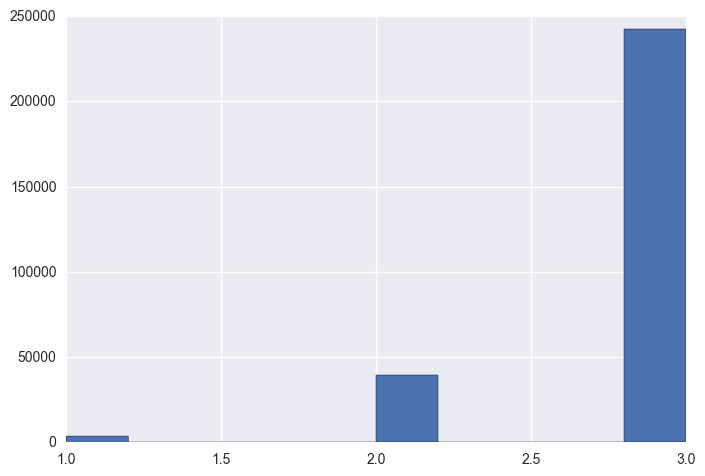

In [6]:
df['Accident_Severity'].hist()
# 1 - Fatal, 2 - Serious, 3 - Slight

Clearly, most accidents are 'slight'. Where the accident severity currently has three categories, we want a target variable that is either 1 or 0. Therefore, for our initial purposes, we shall classify accidents as a worth identifying as those that are either fatal or serious (bad accidents), with the slight accidents being not worth identifying (not bad accidents).

In [43]:
df['SeriousFatal'] = np.where(df['Accident_Severity'] < 3, 1, 0)
acc['SeriousFatal'] = np.where(acc['Accident_Severity'] < 3, 1, 0)
acc[['Accident_Severity', 'SeriousFatal']].head()

,Accident_Severity,SeriousFatal
0,3,0
1,3,0
2,3,0
3,3,0
4,2,1


In [8]:
df['SeriousFatal'].mean()

0.15017039743055385

15% of the accidents are 'bad' accidents. Our job now will be to identify what these accidents have in common.

In [9]:
# Create crosstables for each of the categorical variables with the target variable.
# Have a look for which values of these categorical variables has a higher proportion of bad accidents.
# Any variable & value combination that produces more than 15% bad accidents should be investigated.

categorical_variables = [u'Police_Force',
       'Day_of_Week', 'Local_Authority_(Highway)', '1st_Road_Class',
       'Road_Type', 'Speed_limit', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'Casualty_Class', 'Sex_of_Casualty',
       'Age_Band_of_Casualty', u'Casualty_Severity',
       'Casualty_Type', 'Vehicle_Type',
       'Journey_Purpose_of_Driver', 'Sex_of_Driver', 
       'Age_Band_of_Driver', u'Propulsion_Code']

# Create a dictionary for the variable & value, and the proportion of bad accidents.
prop_dict={}
for var in categorical_variables:
    
    ct = pd.crosstab(index=df['SeriousFatal'], columns=df[var], normalize='columns')
    
    for x in df[var].unique():
        prop = ct.iloc[1][x]
        
        key = str(var) + " = " + str(x)
        prop_dict[key] = prop
        
#Remove any null proportions
for keyvalue in prop_dict.items():
    if type(keyvalue[1]) is not np.float64:
        del prop_dict[keyvalue[0]]

#Sort based on the proportion        
sorted(prop_dict.items(), key=lambda x:x[1], reverse=True)

[('Casualty_Severity = 2.0', 1.0),
 ('Casualty_Severity = 1.0', 1.0),
 ('Propulsion_Code = 4', 1.0),
 ('Vehicle_Type = 23', 0.55555555555555558),
 ('Casualty_Type = 23.0', 0.55555555555555558),
 ('Local_Authority_(Highway) = S12000020', 0.42553191489361702),
 ('Local_Authority_(Highway) = S12000034', 0.41590214067278286),
 ('Casualty_Type = 5.0', 0.3894599681482554),
 ('Vehicle_Type = 5', 0.38253498385360601),
 ('Police_Force = 92', 0.37988362427265171),
 ('Casualty_Type = 17.0', 0.36046511627906974),
 ('Casualty_Type = 97.0', 0.33333333333333331),
 ('Local_Authority_(Highway) = S12000033', 0.30637254901960786),
 ('Casualty_Type = 4.0', 0.30282375851996107),
 ('Casualty_Type = 90.0', 0.29999999999999999),
 ('Vehicle_Type = 4', 0.2988606485539001),
 ('Casualty_Type = 21.0', 0.29797979797979796),
 ('Local_Authority_(Highway) = E06000017', 0.29608938547486036),
 ('Vehicle_Type = 97', 0.29537366548042704),
 ('Age_Band_of_Casualty = 11.0', 0.29076125052572549),
 ('Local_Authority_(Highway) 

Ignoring the original casualty severity variable, propulsion code and vehicle type are worth investigating more.

## Vehicle Investigation

In [88]:
pd.crosstab(index=df['SeriousFatal'], columns=df['Vehicle_Type'], normalize='columns')

Vehicle_Type,-1,1,2,3,4,5,8,9,10,11,...,17,18,19,20,21,22,23,90,97,98
SeriousFatal,,,,,,,,,,,,,,,,,,,,,
0,0.827586,0.815767,0.823993,0.784272,0.701139,0.617465,0.887143,0.86782,0.776712,0.844914,...,0.724951,0.888889,0.857407,0.830317,0.786337,0.752252,0.444444,0.792883,0.704626,0.858044
1,0.172414,0.184233,0.176007,0.215728,0.298861,0.382535,0.112857,0.13218,0.223288,0.155086,...,0.275049,0.111111,0.142593,0.169683,0.213663,0.247748,0.555556,0.207117,0.295374,0.141956


|**code** |	**label**
|----------------------------------|
|1	      |Pedal cycle
|2	      |Motorcycle 50cc and under
|3	      |Motorcycle 125cc and under
|4	      |Motorcycle over 125cc and up to 500cc
|5	      |Motorcycle over 500cc
|8	      |Taxi/Private hire car
|9	      |Car
|10	      |Minibus (8 - 16 passenger seats)
|11	      |Bus or coach (17 or more pass seats)
|16	      |Ridden horse
|17	      |Agricultural vehicle
|18	      |Tram
|19	      |Van / Goods 3.5 tonnes mgw or under
|20	      |Goods over 3.5t. and under 7.5t
|21	      |Goods 7.5 tonnes mgw and over
|22	      |Mobility scooter
|23	      |Electric motorcycle
|90	      |Other vehicle
|97	      |Motorcycle - unknown cc
|98	      |Goods vehicle - unknown weight
|-1	      |Data missing or out of range


For a bit of clarity, some of the labels can be combined (motorcycles, rare, etc)

In [11]:
def group_vehicle_types(x):
    if x == 2 or x == 3 or x == 4 or x == 5 or x == 23 or x == 97:
        return 'Motorcycle'
    elif x == 19 or x == 20 or x == 21 or x == 98:
        return 'Van/HGV'
    elif x == 9:
        return 'Car'
    elif x == 1:
        return 'Pedal Cycle'
    elif x == 11:
        return 'Bus/Coach'
    elif x == 8:
        return 'Taxi/Private Hire'
    elif x == 90:
        return 'Other'
    elif x == 10:
        return 'Minibus'
    elif x == 16:
        return 'Ridden Horse'
    elif x == 17:
        return 'Agricultural Vehicle'
    elif x == 18:
        return 'Tram'
    elif x == 22:
        return 'Mobility Scooter'
    else:
        return str(x)

df['Vehicle_Type_Grouped'] = df['Vehicle_Type'].apply(group_vehicle_types)
df.head()

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type,Vehicle_IMD_Decile,SeriousFatal,Vehicle_Type_Grouped
0,201501BS70001,525130.0,180050.0,-0.198465,51.505538,1,3,1,1,12/01/2015,...,-1,-1,2143,2,4,-1,-1,-1,0,Van/HGV
1,201501BS70002,526530.0,178560.0,-0.178838,51.491836,1,3,1,1,12/01/2015,...,-1,-1,1600,1,3,-1,-1,-1,0,Car
2,201501BS70004,524610.0,181080.0,-0.205590,51.514910,1,3,1,1,12/01/2015,...,30,6,1686,2,10,-1,1,-1,0,Car
3,201501BS70005,524420.0,181080.0,-0.208327,51.514952,1,3,1,1,13/01/2015,...,-1,-1,-1,-1,-1,-1,-1,-1,0,Car
4,201501BS70008,524630.0,179040.0,-0.206022,51.496572,1,2,2,1,09/01/2015,...,48,8,-1,-1,-1,-1,1,-1,1,Pedal Cycle


In [111]:
#per_acc = df[['Accident_Index', 'SeriousFatal', 'Vehicle_Type_Grouped']].groupby('Accident_Index').first().reset_index()
grpby_veh = df[['Accident_Index', 'SeriousFatal', 'Vehicle_Type_Grouped']].groupby('Vehicle_Type_Grouped').aggregate({'Accident_Index':pd.Series.count, 'SeriousFatal':np.sum}).reset_index()
grpby_veh['Proportion_Serious_or_Fatal'] = grpby_veh['SeriousFatal'] / grpby_veh['Accident_Index']
grpby_veh[grpby_veh['Accident_Index']>1000]

,Vehicle_Type_Grouped,SeriousFatal,Accident_Index,Proportion_Serious_or_Fatal
2,Bus/Coach,1078,6951,0.155086
3,Car,27227,205985,0.132180
6,Motorcycle,6067,21800,0.278303
7,Other,291,1405,0.207117
8,Pedal Cycle,3613,19611,0.184233
10,Taxi/Private Hire,711,6300,0.112857
12,Van/HGV,3500,21812,0.160462


In [145]:
grpby_veh['SeriousFatal'].sum()

42875

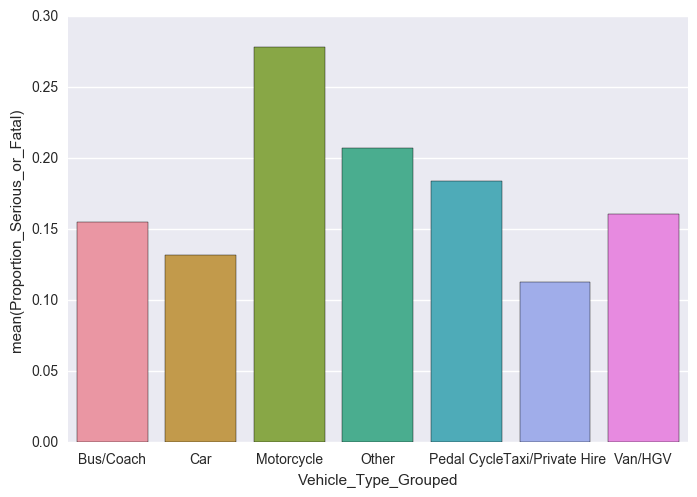

In [110]:
sns.barplot(data=grpby_veh[grpby_veh['Accident_Index']>1000], x='Vehicle_Type_Grouped', y='Proportion_Serious_or_Fatal')

Excluding those modes of transport with less than 1000 accidents in the year, we see that motorcycles are clearly the most dangerous, with 27% of their accidents being serious or fatal.

## Day of Week Investigation

In [16]:
def change_weekday(x):
    days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
    return days[x-1]

In [17]:
df['Day_of_Week_Named'] = df['Day_of_Week'].apply(change_weekday)
df[['Day_of_Week', 'Day_of_Week_Named']].head()

,Day_of_Week,Day_of_Week_Named
0,2,Monday
1,2,Monday
2,2,Monday
3,3,Tuesday
4,6,Friday


In [22]:
gb_accidents = df.groupby('Accident_Index').first()
gb_accidents.reset_index(inplace=True)
gb_accidents = gb_accidents.groupby('Day_of_Week_Named').agg({"Accident_Index": pd.Series.nunique, 'SeriousFatal': np.sum})
gb_accidents.reset_index(inplace=True)
gb_accidents['Proportion_SeriousFatal'] = gb_accidents['SeriousFatal']/gb_accidents['Accident_Index']
gb_accidents

,Day_of_Week_Named,SeriousFatal,Accident_Index,Proportion_SeriousFatal
0,Friday,3425,22374,0.153079
1,Monday,2892,20032,0.144369
2,Saturday,3131,18114,0.172850
3,Sunday,2838,15258,0.186001
4,Thursday,3107,21479,0.144653
5,Tuesday,3098,21431,0.144557
6,Wednesday,3163,21368,0.148025


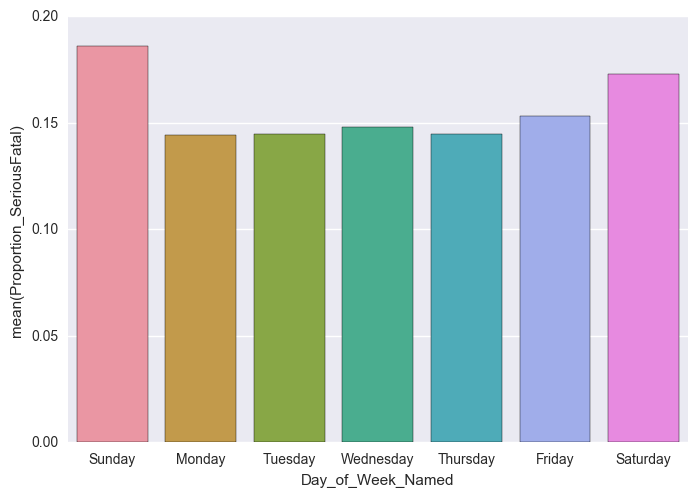

In [23]:
sns.barplot(x='Day_of_Week_Named', y='Proportion_SeriousFatal', data=gb_accidents,
           order=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])

## Light Conditions Investigation

In [27]:
acc['Light_Conditions'].value_counts()

1    102608
4     27551
6      7258
7      1920
5       719
Name: Light_Conditions, dtype: int64

In [44]:
pd.crosstab(index=acc['SeriousFatal'], columns=acc['Light_Conditions'], normalize='index')

Light_Conditions,1,4,5,6,7
SeriousFatal,,,,,
0,0.740047,0.195731,0.004789,0.045835,0.013598
1,0.692020,0.202087,0.007019,0.084557,0.014316


8.5% of all serious or fatal accidents occur when there is no lighting in darkness.

In [45]:
pd.crosstab(index=acc['SeriousFatal'], columns=acc['Light_Conditions'], normalize='columns')

Light_Conditions,1,4,5,6,7
SeriousFatal,,,,,
0,0.853959,0.841167,0.788595,0.747727,0.838542
1,0.146041,0.158833,0.211405,0.252273,0.161458


25% of all accidents that occur when there is no lighting in darkness are serious or fatal.

In [113]:
def named_light_conditions(x):
    if x==1:
        return 'Light'
    elif x==4:
        return 'Darkness with Lights Lit'
    elif x==5 or x==6:
        return 'Darkness with Lights Unlit / No Light'
    elif x==7:
        return 'Darkness with Lighting Unknown'
    else:
        return 'Missing'

acc['Light_Conditions_Named'] = acc['Light_Conditions'].apply(named_light_conditions)
df['Light_Conditions_Named'] = df['Light_Conditions'].apply(named_light_conditions)

In [47]:
acc[['Light_Conditions', 'Light_Conditions_Named']].head()

,Light_Conditions,Light_Conditions_Named
0,4,Darkness with Lights Lit
1,1,Light
2,4,Darkness with Lights Lit
3,1,Light
4,1,Light


In [131]:
grpby_light = acc[['Accident_Index', 'SeriousFatal', 'Light_Conditions_Named']].groupby('Light_Conditions_Named').aggregate({'Accident_Index':pd.Series.count, 'SeriousFatal':np.sum})
grpby_light['Proportion_Serious_or_Fatal'] = grpby_light['SeriousFatal'] / grpby_light['Accident_Index']
grpby_light.reset_index(inplace=True)
grpby_light

,Light_Conditions_Named,SeriousFatal,Accident_Index,Proportion_Serious_or_Fatal
0,Darkness with Lighting Unknown,310,1920,0.161458
1,Darkness with Lights Lit,4376,27551,0.158833
2,Darkness with Lights Unlit / No Light,1983,7977,0.248590
3,Light,14985,102608,0.146041


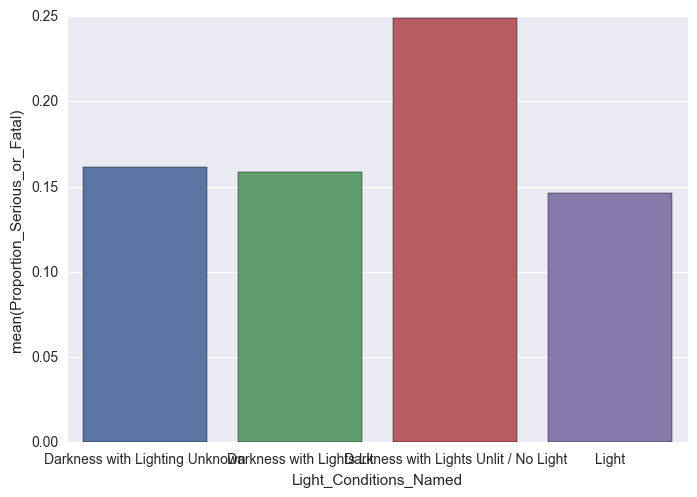

In [86]:
sns.barplot(data=grpby_light, x='Light_Conditions_Named', y='Proportion_Serious_or_Fatal')

Accidents are more likely to be serious or fatal if they are in darkness with no light compared with other lighting conditions.

## Propulsion

In [100]:
df[['Accident_Index', 'SeriousFatal', 'Propulsion_Code']].groupby('Propulsion_Code').aggregate({'Accident_Index':pd.Series.nunique, 'SeriousFatal':np.sum})

,SeriousFatal,Accident_Index
Propulsion_Code,,
-1,12164,57989
1,18338,82994
2,12142,63472
3,17,120
4,4,3
5,9,34
6,5,53
7,18,169
8,171,1921


Perhaps there are too few examples of each to really do much with this - also lots of missing data.

## Sex of Driver

In [104]:
grpby_sex = df[['Accident_Index', 'SeriousFatal', 'Sex_of_Driver']].groupby('Sex_of_Driver').aggregate({'Accident_Index':pd.Series.nunique, 'SeriousFatal':np.sum})
grpby_sex['Proportion_Serious_or_Fatal'] = grpby_sex['SeriousFatal'] / grpby_sex['Accident_Index']
grpby_sex

,SeriousFatal,Accident_Index,Proportion_Serious_or_Fatal
Sex_of_Driver,,,
-1,2,19,0.105263
1,31087,115539,0.269061
2,9623,60507,0.159039
3,2163,15150,0.142772


Males have nearly twice as many accidents as women. Since we would expect road usage to be roughly similar across the sexes, we can say that males are twice as likely to have accidents.

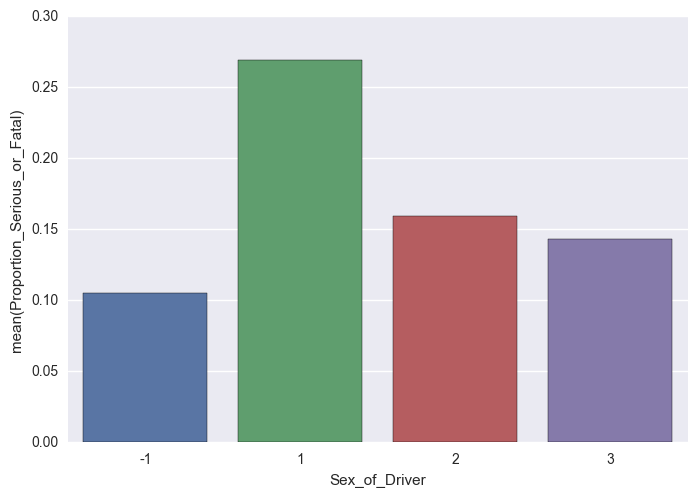

In [106]:
grpby_sex.reset_index(inplace=True)
sns.barplot(data=grpby_sex, x='Sex_of_Driver', y='Proportion_Serious_or_Fatal')

Males' accidents are far more likely to be serious or fatal.

In [158]:
def univariate_proportion(data, field_name):
    grpby = data[['Accident_Index', 'SeriousFatal', field_name]].groupby(field_name).aggregate({'Accident_Index':pd.Series.nunique, 'SeriousFatal':np.sum})
    grpby['Proportion_Serious_or_Fatal'] = grpby['SeriousFatal'] / grpby['Accident_Index']
    return grpby

In [165]:
univariate_proportion(df, 'Age_Band_of_Driver')

,SeriousFatal,Accident_Index,Proportion_Serious_or_Fatal
Age_Band_of_Driver,,,
-1,3172,27261,0.116357
1,7,67,0.104478
2,64,434,0.147465
3,268,1511,0.177366
4,3664,17672,0.207334
5,5004,27368,0.182841
6,8180,47116,0.173614
7,6930,39946,0.173484
8,7114,36746,0.193599


## Bivariate Analysis

In [164]:
def bivariate_proportion(data, field_name1, field_name2):
    grpby = data[['Accident_Index', 'SeriousFatal', field_name1, field_name2]].groupby([field_name1, field_name2]).aggregate({'Accident_Index':pd.Series.nunique, 'SeriousFatal':np.sum})
    grpby['Proportion_Serious_or_Fatal'] = grpby['SeriousFatal'] / grpby['Accident_Index']
    return grpby

In [172]:
grpby = bivariate_proportion(df, 'Sex_of_Driver', 'Age_Band_of_Driver')
grpby[grpby['Proportion_Serious_or_Fatal']>0.2]

SeriousFatal  Accident_Index  \
Sex_of_Driver Age_Band_of_Driver                                 
-1            6                              1               1   
              9                              1               1   
 1            4                           2973           12898   
              5                           3913           18890   
              8                           5370           26319   
              9                           3361           15181   
              10                          1728            7621   
              11                          1278            4639   
 2            11                           479            2017   
 3            3                              1               1   
              4                             12              50   
              5                             21             102   

                                  Proportion_Serious_or_Fatal  
Sex_of_Driver Age_Band_of_Driver                               
-1            6                                      1.000000  
              9                                      1.000000  
 1            4                                      0.230501  
              5                                      0.207147  
              8                                      0.204035  
              9                                      0.221395  
              10                                     0.226742  
              11                                     0.275490  
 2            11                                     0.237481  
 3            3                                      1.000000  
              4                                      0.240000  
              5                                      0.205882

In [147]:
grpby_veh_light = df[['Accident_Index', 'SeriousFatal', 'Vehicle_Type_Grouped', 'Light_Conditions_Named']].groupby(['Vehicle_Type_Grouped', 'Light_Conditions_Named']).aggregate({'Accident_Index':pd.Series.nunique, 'SeriousFatal':np.sum})
grpby_veh_light['Proportion_Serious_or_Fatal'] = grpby_veh_light['SeriousFatal'] / grpby_veh_light['Accident_Index']
grpby_veh_light = grpby_veh_light[grpby_veh_light['Accident_Index']>50]
grpby_veh_light[grpby_veh_light['Proportion_Serious_or_Fatal']>0.3]

SeriousFatal  \
Vehicle_Type_Grouped Light_Conditions_Named                                
Bus/Coach            Darkness with Lights Unlit / No Light            38   
Car                  Darkness with Lights Unlit / No Light          3209   
Minibus              Darkness with Lights Lit                         32   
                     Light                                           114   
Motorcycle           Darkness with Lights Unlit / No Light           294   
Other                Darkness with Lights Unlit / No Light            24   
Pedal Cycle          Darkness with Lights Unlit / No Light           128   
Van/HGV              Darkness with Lights Unlit / No Light           405   

                                                            Accident_Index  \
Vehicle_Type_Grouped Light_Conditions_Named                                  
Bus/Coach            Darkness with Lights Unlit / No Light              63   
Car                  Darkness with Lights Unlit / No Light            7151   
Minibus              Darkness with Lights Lit                           80   
                     Light                                             377   
Motorcycle           Darkness with Lights Unlit / No Light             625   
Other                Darkness with Lights Unlit / No Light              60   
Pedal Cycle          Darkness with Lights Unlit / No Light             321   
Van/HGV              Darkness with Lights Unlit / No Light            1146   

                                                            Proportion_Serious_or_Fatal  
Vehicle_Type_Grouped Light_Conditions_Named                                              
Bus/Coach            Darkness with Lights Unlit / No Light                     0.603175  
Car                  Darkness with Lights Unlit / No Light                     0.448748  
Minibus              Darkness with Lights Lit                                  0.400000  
                     Light                                                     0.302387  
Motorcycle           Darkness with Lights Unlit / No Light                     0.470400  
Other                Darkness with Lights Unlit / No Light                     0.400000  
Pedal Cycle          Darkness with Lights Unlit / No Light                     0.398754  
Van/HGV              Darkness with Lights Unlit / No Light                     0.353403

Since this is breaking it down to a 'player' level (ie vehicle or person), the probabilities seem inconsistent with the lighting conditions EDA above.

In [133]:
acc.columns

Index([u'Accident_Index', u'Location_Easting_OSGR', u'Location_Northing_OSGR',
       u'Longitude', u'Latitude', u'Police_Force', u'Accident_Severity',
       u'Number_of_Vehicles', u'Number_of_Casualties', u'Date', u'Day_of_Week',
       u'Time', u'Local_Authority_(District)', u'Local_Authority_(Highway)',
       u'1st_Road_Class', u'1st_Road_Number', u'Road_Type', u'Speed_limit',
       u'Junction_Detail', u'Junction_Control', u'2nd_Road_Class',
       u'2nd_Road_Number', u'Pedestrian_Crossing-Human_Control',
       u'Pedestrian_Crossing-Physical_Facilities', u'Light_Conditions',
       u'Weather_Conditions', u'Road_Surface_Conditions',
       u'Special_Conditions_at_Site', u'Carriageway_Hazards',
       u'Urban_or_Rural_Area', u'Did_Police_Officer_Attend_Scene_of_Accident',
       u'LSOA_of_Accident_Location', u'Light_Conditions2',
       u'Light_Conditions3', u'SeriousFatal', u'Light_Conditions_Named'],
      dtype='object')